🧹 Bloc 1 — Data cleaning → X_train_prepro.csv

In [ ]:
import pandas as pd, re, html, os
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

X = pd.read_csv("../data/X_train_update.csv")
Y = pd.read_csv("../data/Y_train_CVw08PX.csv", usecols=["prdtypecode"])
df = X.copy()
df["label"] = Y["prdtypecode"]

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = BeautifulSoup(text, "html.parser").get_text(" ")
    text = html.unescape(text)
    text = re.sub(r"[^A-Za-zÀ-ÖØ-öø-ÿ0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

tqdm.pandas(desc="🧹 Nettoyage texte")
df["text"] = (df["designation"].fillna("") + " " + df["description"].fillna("")).progress_apply(clean_text)

os.makedirs("data", exist_ok=True)
df[["productid","imageid","text","label"]].to_csv("data/X_train_prepro.csv", index=False)
print("✅ data/X_train_prepro.csv :", df.shape)


🧹 Nettoyage texte:   0%|          | 0/84916 [00:00<?, ?it/s]

✅ data/X_train_prepro.csv : (84916, 7)


In [ ]:
🔤 Bloc 2 — TF-IDF (sparse) → X_text_sparse.npz + tfidf_vectorizer.joblib + y.npy

In [2]:
# --- BLOC 2 : Préprocessing texte (TF-IDF word-only) ---
# !pip install scikit-learn tqdm joblib pandas

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
import joblib, os
from scipy import sparse

# === 1️⃣ Chargement du texte nettoyé ===
print("📂 Lecture du CSV nettoyé...")
df = pd.read_csv("data/X_train_prepro.csv")
print(f"✅ Lignes : {len(df)}")

# === 2️⃣ TF-IDF (uniquement sur les mots) ===
print("🔤 Construction du TF-IDF (mots + bi-grammes)...")

tfidf = TfidfVectorizer(
    max_features=20000,      # limite stricte
    ngram_range=(1, 2),      # mots simples + bi-grammes
    sublinear_tf=True,
    min_df=2                 # ignorer termes rares
)

tqdm.pandas(desc="TF-IDF (mots)")
X_tfidf = tfidf.fit_transform(tqdm(df["text"], desc="Vectorisation TF-IDF"))
y = df["label"].values

print(f"✅ X_text_sparse: {X_tfidf.shape} | y: {y.shape}")

# === 3️⃣ Sauvegardes ===
os.makedirs("data/processed", exist_ok=True)

sparse.save_npz("data/processed/X_text_sparse.npz", X_tfidf)
joblib.dump(tfidf, "data/processed/tfidf_vectorizer.joblib")
import numpy as np
np.save("data/processed/y.npy", y)

print("💾 Sauvegardes :")
print(" - data/processed/X_text_sparse.npz")
print(" - data/processed/tfidf_vectorizer.joblib")
print(" - data/processed/y.npy")


📂 Lecture du CSV nettoyé...
✅ Lignes : 84916
🔤 Construction du TF-IDF (mots + bi-grammes)...


Vectorisation TF-IDF:   0%|          | 0/84916 [00:00<?, ?it/s]

✅ X_text_sparse: (84916, 20000) | y: (84916,)
💾 Sauvegardes :
 - data/processed/X_text_sparse.npz
 - data/processed/tfidf_vectorizer.joblib
 - data/processed/y.npy


🖼️ Bloc 3 — Embeddings images (ResNet50) → X_img.npy

In [3]:
import torch, os, numpy as np, pandas as pd
from torch import nn
from torchvision import models, transforms
from PIL import Image
from tqdm.auto import tqdm

CSV_PATH = "data/X_train_prepro.csv"
IMG_DIR  = "data/images/images/image_train"  # <— ton dossier d’images
OUT_PATH = "data/processed/X_img.npy"

df = pd.read_csv(CSV_PATH)
image_ids = df["imageid"].astype(str).tolist()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()
resnet.eval().to(device)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

batch_size = 32
feats = []
for i in tqdm(range(0, len(image_ids), batch_size), desc="🧠 ResNet50 embeddings"):
    batch_tensors = []
    for iid in image_ids[i:i+batch_size]:
        path = os.path.join(IMG_DIR, f"{iid}.jpg")
        try:
            img = Image.open(path).convert("RGB")
            x = preprocess(img)
        except Exception:
            x = torch.zeros(3,224,224)  # image manquante/cassée
        batch_tensors.append(x)
    xb = torch.stack(batch_tensors).to(device)
    with torch.no_grad():
        emb = resnet(xb).cpu().numpy()  # (B, 2048, 1, 1) ou (B, 2048)
        emb = emb.reshape(emb.shape[0], -1)
    feats.append(emb)

X_img = np.vstack(feats).astype(np.float32)
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
np.save(OUT_PATH, X_img)
print("✅ X_img:", X_img.shape, "→", OUT_PATH)


🧠 ResNet50 embeddings:   0%|          | 0/2654 [00:00<?, ?it/s]

✅ X_img: (84916, 2048) → data/processed/X_img.npy


🔗 Bloc 4 — Fusion texte+image → X_all_sparse.npz

In [4]:
import numpy as np
from scipy import sparse

X_text = sparse.load_npz("data/processed/X_text_sparse.npz")   # CSR
X_img  = np.load("data/processed/X_img.npy")                   # (N, 2048)

# Convertir image en CSR et concaténer horizontalement
X_img_csr = sparse.csr_matrix(X_img)   # float32 OK
X_all = sparse.hstack([X_text, X_img_csr]).tocsr()

sparse.save_npz("data/processed/X_all_sparse.npz", X_all)
print("✅ X_all_sparse:", X_all.shape)


✅ X_all_sparse: (84916, 22048)


🧠 Bloc 5 — Entraînement XGBoost (progress bar) → modèles + métriques

In [5]:
import numpy as np, os, json, joblib, xgboost as xgb
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm.auto import tqdm

X = sparse.load_npz("data/processed/X_all_sparse.npz")
y = np.load("data/processed/y.npy")

encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

params = {
    "objective": "multi:softprob",
    "num_class": len(np.unique(y_enc)),
    "eval_metric": ["mlogloss", "merror"],
    "eta": 0.1,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
}

class TQDMProgress(xgb.callback.TrainingCallback):
    def __init__(self, total): self.pbar = tqdm(total=total, desc="🧠 Training")
    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        tr = evals_log["train"]["mlogloss"][-1]; va = evals_log["val"]["mlogloss"][-1]
        self.pbar.set_postfix({"train": f"{tr:.4f}", "val": f"{va:.4f}"})
        return False
    def after_training(self, model): self.pbar.close(); return model

num_round = 200
evals_result = {}
os.makedirs("data/models", exist_ok=True)

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=[(dtrain,"train"), (dval,"val")],
    evals_result=evals_result,
    verbose_eval=False,
    callbacks=[TQDMProgress(num_round)],
)

y_pred = np.argmax(bst.predict(dval), axis=1)
acc = accuracy_score(y_val, y_pred)
f1  = f1_score(y_val, y_pred, average="weighted")
print(f"✅ Accuracy: {acc:.4f} | F1: {f1:.4f}")
print("=== Rapport (résumé) ===")
print(classification_report(y_val, y_pred, digits=3)[:1000])

bst.save_model("data/models/xgb_fusion.json")
joblib.dump(encoder, "data/models/label_encoder.joblib")
json.dump({"accuracy": float(acc), "f1": float(f1)}, open("data/models/metrics_fusion.json","w"))
print("💾 Modèle: data/models/xgb_fusion.json | Encodeur: data/models/label_encoder.joblib")


🧠 Training:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Accuracy: 0.8067 | F1: 0.8094
=== Rapport (résumé) ===
              precision    recall  f1-score   support

           0      0.384     0.615     0.473       623
           1      0.754     0.588     0.661       502
           2      0.825     0.798     0.811       336
           3      0.958     0.831     0.890       166
           4      0.766     0.749     0.758       534
           5      0.920     0.886     0.903       791
           6      0.800     0.523     0.632       153
           7      0.738     0.751     0.744       974
           8      0.651     0.541     0.591       414
           9      0.949     0.934     0.941      1009
          10      0.968     0.925     0.946       161
          11      0.889     0.737     0.806       498
          12      0.793     0.739     0.765       648
          13      0.836     0.830     0.833      1015
          14      0.923     0.929     0.926       861
          15      0.879     0.770     0.821       161
          16      0.774 

📊 Bloc 6 — Matrice de confusion (affichage uniquement)

📦 Chargement du modèle et des données...
🔮 Prédiction en cours...
📊 Calcul de la matrice de confusion...


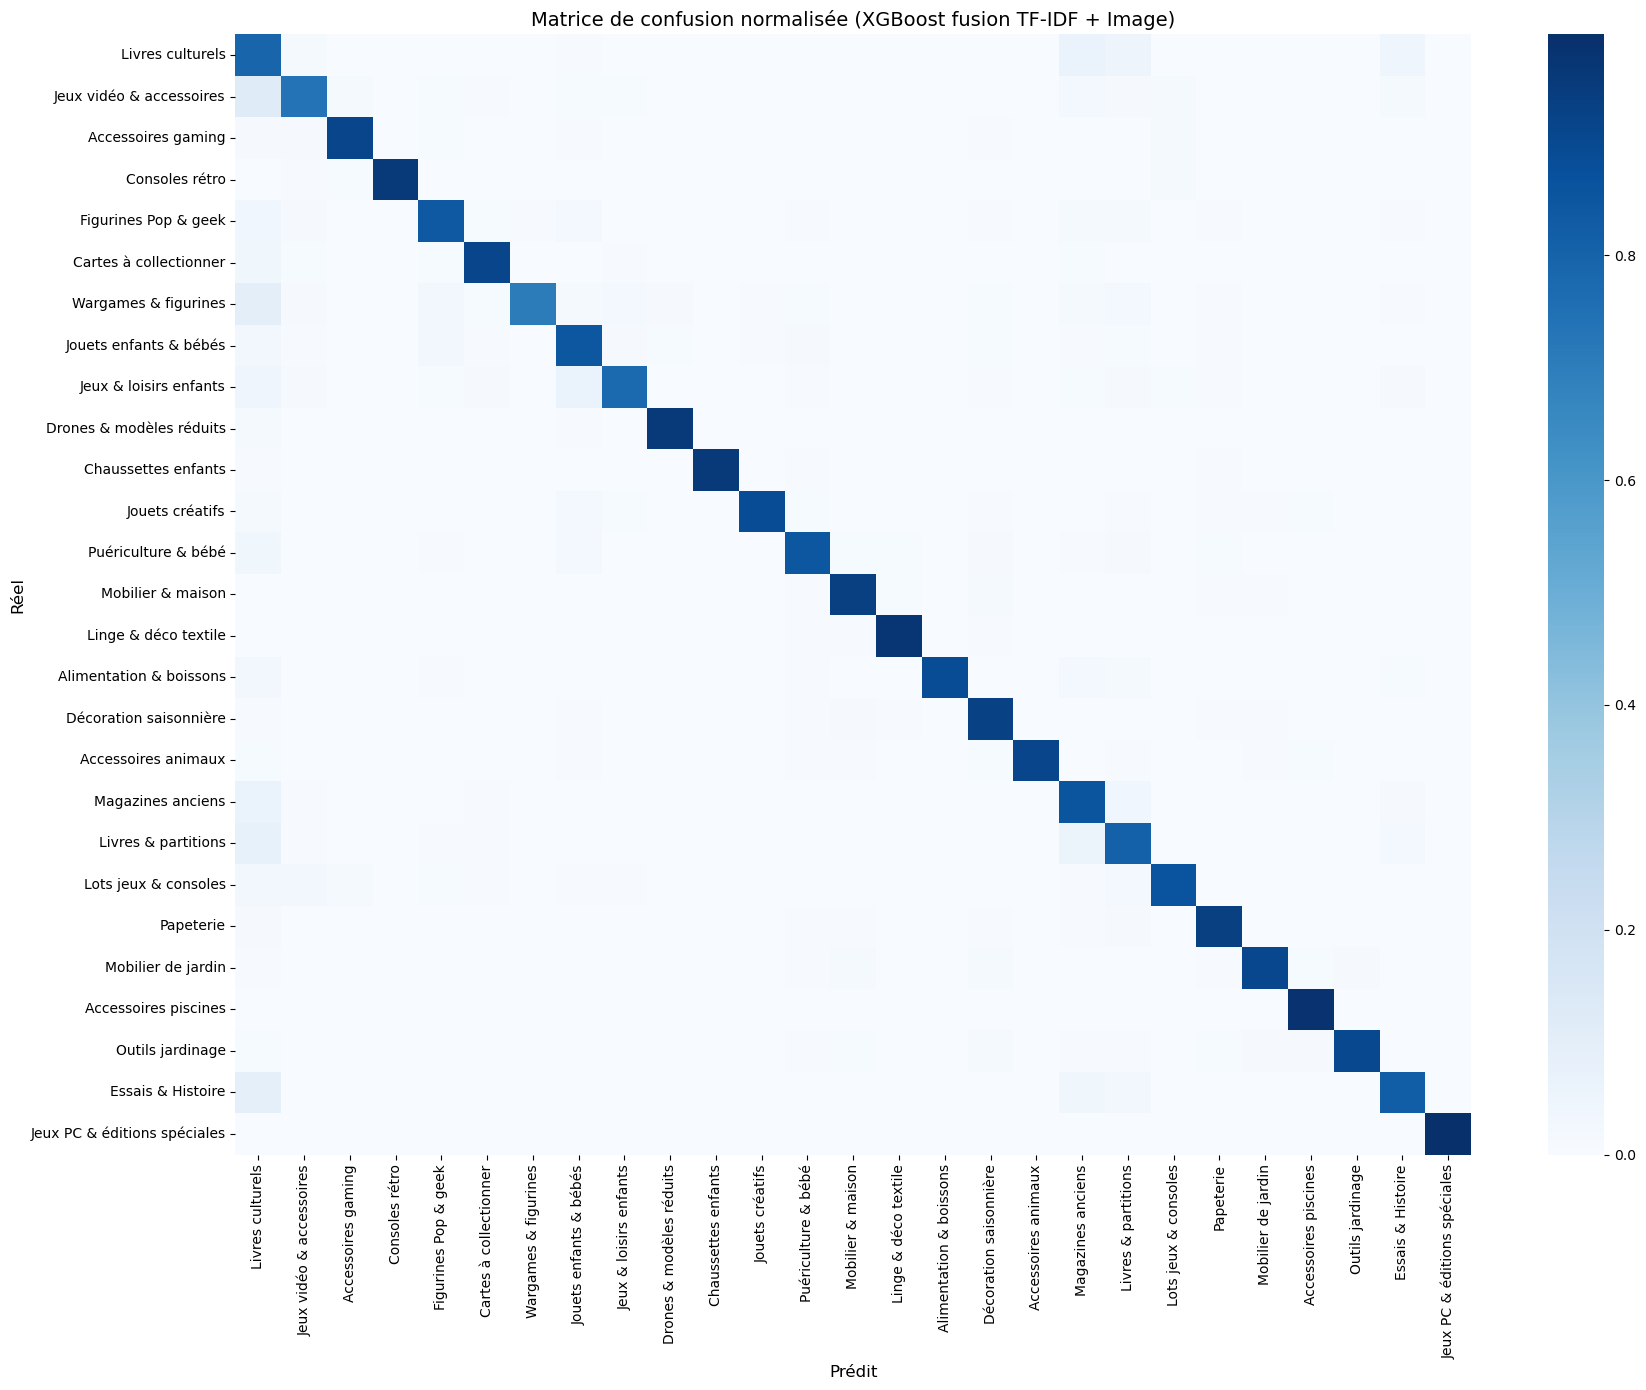

In [4]:
# --- MATRICE DE CONFUSION AUTONOME ---
# !pip install seaborn matplotlib pandas xgboost scikit-learn joblib tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, xgboost as xgb
from scipy import sparse
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm

# === 1️⃣ Chargement des artefacts ===
print("📦 Chargement du modèle et des données...")
X = sparse.load_npz("data/processed/X_all_sparse.npz")
y = np.load("data/processed/y.npy")

encoder = joblib.load("data/models/label_encoder.joblib")
bst = xgb.Booster()
bst.load_model("data/models/xgb_fusion.json")

# === 2️⃣ Prédiction sur tout le dataset ===
print("🔮 Prédiction en cours...")
dtest = xgb.DMatrix(X)
y_pred = np.argmax(bst.predict(dtest), axis=1)
y_true = encoder.transform(y)

# === 3️⃣ Mapping prdtypecode → noms de catégories ===
cat_map = {
    10: "Livres culturels",
    40: "Jeux vidéo & accessoires",
    50: "Accessoires gaming",
    60: "Consoles rétro",
    1140: "Figurines Pop & geek",
    1160: "Cartes à collectionner",
    1180: "Wargames & figurines",
    1280: "Jouets enfants & bébés",
    1281: "Jeux & loisirs enfants",
    1300: "Drones & modèles réduits",
    1301: "Chaussettes enfants",
    1302: "Jouets créatifs",
    1320: "Puériculture & bébé",
    1560: "Mobilier & maison",
    1920: "Linge & déco textile",
    1940: "Alimentation & boissons",
    2060: "Décoration saisonnière",
    2220: "Accessoires animaux",
    2280: "Magazines anciens",
    2403: "Livres & partitions",
    2462: "Lots jeux & consoles",
    2522: "Papeterie",
    2582: "Mobilier de jardin",
    2583: "Accessoires piscines",
    2585: "Outils jardinage",
    2705: "Essais & Histoire",
    2905: "Jeux PC & éditions spéciales",
}

# === 4️⃣ Noms dans l’ordre de l’encodeur ===
prdcodes = encoder.classes_
names = [cat_map.get(int(c), str(c)) for c in prdcodes]

# === 5️⃣ Matrice de confusion ===
print("📊 Calcul de la matrice de confusion...")
cm = confusion_matrix(y_true, y_pred, normalize="true")

plt.figure(figsize=(18, 14))
sns.heatmap(cm, cmap="Blues", xticklabels=names, yticklabels=names, cbar=True)
plt.title("Matrice de confusion normalisée (XGBoost fusion TF-IDF + Image)", fontsize=14)
plt.xlabel("Prédit", fontsize=12)
plt.ylabel("Réel", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
